<a href="https://colab.research.google.com/github/Aburoobha/FUNDUS-image-classification/blob/main/IMAGE_CLASSIFIER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download linchundan/fundusimage1000 -p "/content/sample_data"
!unzip "/content/sample_data/fundusimage1000.zip" -d "/content/sample_data"
!rm -rf "/content/sample_data/fundusimage1000.zip"
!rm -rf "/content/sample_data/1000images/1000images"

In [ ]:
!rm -rf "/content/sample_data"

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.applications import VGG16
from keras.regularizers import l2


In [ ]:
batch_size = 32
epochs = 100

In [ ]:
# Load images and labels into numpy arrays
def load_images_and_labels(dataset_dir, img_size=(128, 128)):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_dir))
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(dataset_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is None: # Check if image loaded successfully
                print(f"Failed to load image: {img_path}")
                continue # Skip to next image if loading failed
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(class_indices[class_name])

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_indices

In [ ]:
dataset_dir = '/content/sample_data/1000images'
img_size = (128, 128)
images, labels, class_indices = load_images_and_labels(dataset_dir, img_size)

In [ ]:
# Normalize images
images = images / 255.0

# One-hot encode labels
num_classes = len(class_indices)
labels = to_categorical(labels, num_classes)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create an ImageDataGenerator object for augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the datagen on the training data
datagen.fit(X_train)

# Load the VGG16 model
input_shape = (128, 128, 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the last few layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Model Training
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test))

Epoch 1/100
25/25 [==============================] - 10s 202ms/step - loss: 4.1170 - accuracy: 0.0388 - val_loss: 3.9198 - val_accuracy: 0.1150
Epoch 2/100
25/25 [==============================] - 6s 231ms/step - loss: 3.9860 - accuracy: 0.0650 - val_loss: 3.8282 - val_accuracy: 0.1600
Epoch 3/100
25/25 [==============================] - 5s 196ms/step - loss: 3.8564 - accuracy: 0.1063 - val_loss: 3.6909 - val_accuracy: 0.1950
Epoch 4/100
25/25 [==============================] - 5s 204ms/step - loss: 3.7338 - accuracy: 0.1538 - val_loss: 3.4976 - val_accuracy: 0.2250
Epoch 5/100
25/25 [==============================] - 6s 236ms/step - loss: 3.5320 - accuracy: 0.2037 - val_loss: 3.2858 - val_accuracy: 0.2750
Epoch 6/100
25/25 [==============================] - 5s 184ms/step - loss: 3.4011 - accuracy: 0.2125 - val_loss: 3.1561 - val_accuracy: 0.3150
Epoch 7/100
25/25 [==============================] - 6s 230ms/step - loss: 3.3428 - accuracy: 0.2188 - val_loss: 3.1241 - val_accuracy: 0.310

In [ ]:
# Model Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')

7/7 [==============================] - 0s 45ms/step - loss: 1.6818 - accuracy: 0.6800
Test accuracy: 0.68


In [ ]:
# Save the Model (Optional)
model.save('fundus_cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


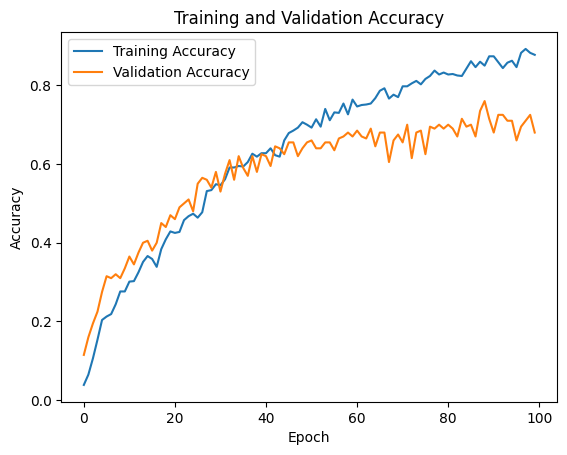

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

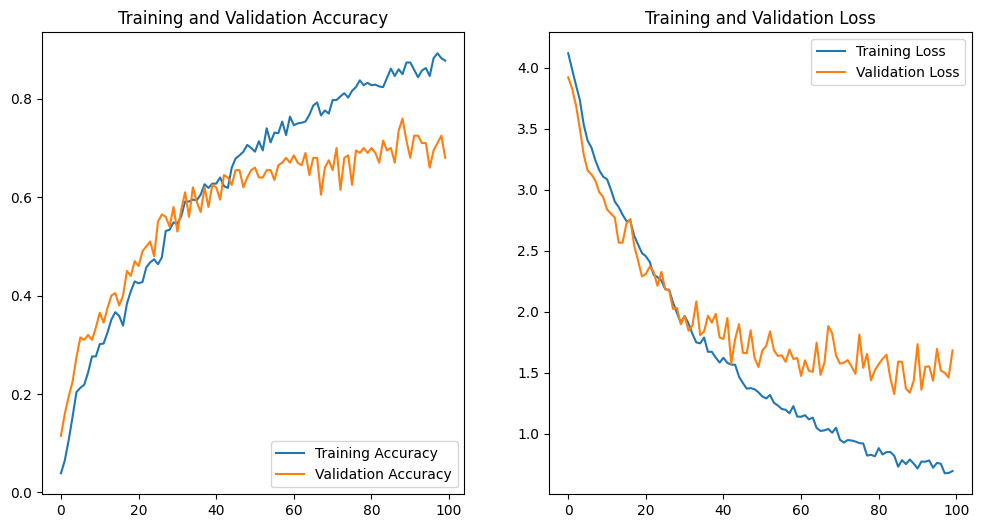

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Predict the labels for the test set
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = np.argmax(y_test, axis=1)

# Get the class indices
class_labels = list(class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels, labels=range(num_classes)))

# Print confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
print(cm)

7/7 [==============================] - 0s 63ms/step
                                              precision    recall  f1-score   support

                                  0.0.Normal       0.19      0.75      0.30         4
                      0.1.Tessellated fundus       0.50      1.00      0.67         2
                         0.2.Large optic cup       0.87      0.93      0.90        14
                                     0.3.DR1       0.67      0.67      0.67         3
                                     1.0.DR2       0.60      0.60      0.60         5
                                     1.1.DR3       0.00      0.00      0.00         5
                      10.0.Possible glaucoma       1.00      0.17      0.29         6
                          10.1.Optic atrophy       0.33      1.00      0.50         1
          11.Severe hypertensive retinopathy       1.00      0.67      0.80         3
              12.Disc swelling and elevation       0.00      0.00      0.00         4
 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.